# Avoid computing the boundaries again
*note*: For the next 3 scenarios, it is necessary to click on "cell>Run All above" after browsing to the target cell and clicking on it, this will load the needed dependencies.  
- 1D displacement test
- 2D source point test
- Generate EVs in a pre processed cross section  

[load the dependencies](#Dependencies)

*Otherwise:*  
[Load the dependencies](#Dependencies) first and then proceed to [Process a new cross section](#The-full-pipeline) 

In [65]:
from imageio import imread
from skimage import measure
from skimage.transform import rescale
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
%matplotlib inline
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
import os
import sys
import math
import random
from math import radians
import copy
import pickle
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from struct import pack

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utilities.geometry import Plane, middle_point, two_points_normals_2d, project_point_on_direction, distance


class Segment(object):
    def __init__(self, x1, y1, x2, y2, mx, my, nx, ny, l, s_id):
        self.p1x = x1
        self.p1y = y1
        self.p2x = x2
        self.p2y = y2
        self.mpx = mx
        self.mpy = my
        mag = np.sqrt(nx * nx + ny * ny)
        self.direction_x = nx / mag
        self.direction_y = ny / mag
        self.normalx = nx
        self.normaly = ny
        self.length = l
        self.section_id = s_id
        
    def location(self):
        return np.array([self.mpx, self.mpy])

    def direction(self):
        return np.array([self.direction_x, self.direction_y])

class Cell(Segment):
    def __init__(self, _id, p1x, p1y, p2x, p2y, mpx, mpy, dirx, diry, diameter, section_id):
        super(Cell, self).__init__(p1x, p1y, p2x, p2y, mpx, mpy, dirx, diry, diameter, section_id)
        self._id = _id
        self.radius = diameter / 2.
    
    def getXmlDescription(self):
        raise NotImplementedError("Method not yet implemented!!!")
    
    def getCoords(self):
        return [(self.p1x, self.p1y),(self.p2x, self.p2y)]
    
    def angle(self):
        return np.arctan2(self.p2y - self.p1y, self.p2x - self.p1x) #* 180./np.pi
    
    def getXmlDescription(self):
        return """
    <xagent>
        <name>{}</name>
        <id>{:d}</id>
        <p1_x>{:f}</p1_x>
        <p1_y>{:f}</p1_y>
        <p2_x>{:f}</p2_x>
        <p2_y>{:f}</p2_y>
        <x>{:f}</x>
        <y>{:f}</y>
        <direction_x>{:f}</direction_x>
        <direction_y>{:f}</direction_y>
        <angle>{:f}</angle>
        <time_since_last_secreted>0</time_since_last_secreted>
        <section>{:d}</section>
    </xagent>""".format(self.name, self._id, self.p1x, self.p1y, self.p2x, self.p2y, self.mpx, 
                            self.mpy, self.direction_x, self.direction_y, self.angle(), self.section_id)
        
class SecretoryCell(Cell):
    def __init__(self, _id, p1x, p1y, p2x, p2y, mpx, mpy, dirx, diry, diameter, section_id):
        super(SecretoryCell, self).__init__(_id, p1x, p1y, p2x, p2y, mpx, mpy, dirx, diry, diameter, section_id)
        self.name = 'SecretoryCell'


class CiliaryCell(Cell):
    def __init__(self, _id, p1x, p1y, p2x, p2y, mpx, mpy, dirx, diry, diameter, section_id):
        super(CiliaryCell, self).__init__(_id, p1x, p1y, p2x, p2y, mpx, mpy, dirx, diry, diameter, section_id)
        self.name = 'CiliaryCell'


class EV:
    # to convert:
    # N square metres to square micrometre: multiply N * 1e+12
    # N metres to micrometres: multiply N * 1e+6
    # N micrometres to metres: divide N / 1e+6   
    def random_diameter_nm(self):
        return random.randint(3, 30) * 10
    
    def mass_from_diameter(self):
        # update function to compute the mass as a function of the volume
        # assume spherical shape and same material density 
        # with an estimated mass of 5.47990700763866E-20 for an EV of radius 100 nm
        # Mass = density * volume, Volume = 4/3*Pi*radius^3
        # return 5.47991E-20 * self.diameter_um
        ev_mass_per_radius_um = {
        30:1.47957E-21, 40:3.50714E-21, 50:6.84988E-21, 60:1.18366E-20, 70:1.87961E-20,
        80:2.80571E-20, 90:3.99485E-20, 100:5.47991E-20, 110:7.29376E-20, 120:9.46928E-20,
        130:1.20394E-19, 140:1.50369E-19, 150:1.84947E-19, 160:2.24457E-19, 170:2.69228E-19,
        180:3.19588E-19, 190:3.75867E-19, 200:4.38393E-19, 210:5.07494E-19, 220:5.835E-19,
        230:6.6674E-19, 240:7.57542E-19, 250:8.56235E-19, 260:9.63148E-19, 270:1.07861E-18,
        280:1.20295E-18, 290:1.33649E-18, 300:1.47957E-18}
        
        return ev_mass_per_radius_um[self.diameter_nm]
    
    def __init__(self, *args, **kwargs):
        self._id = kwargs.get('_id', 0)
        self.x_1 = kwargs.get('x_1', 0) # holds the starting position for this EV
        self.y_1 = kwargs.get('y_1', 0)
        self.vx = kwargs.get('vx', 0)
        self.vy = kwargs.get('vy', 0)
        self.diameter_nm = self.random_diameter_nm()
        self.diameter_um = kwargs.get('diameter_nm', self.diameter_nm) / 1000
        self.diameter_m = self.diameter_um / 1e6
        
        self.colour = '()'
        
        self.radius_um = (self.diameter_um / 2)
        self.radius_m = self.radius_um / 1e+6
        
        self.mass_Kg = self.mass_from_diameter()

        # Compute the radius-dependent diffusion coefficient defined as
        # D = (boltzmann tempK)/(6 pi fluidViscosity particleRadius)
        self.diffusion_rate_m = ((const_Boltzmann * const_Temperature_K) 
                                 / (6. * math.pi * const_water_viscosity * self.radius_m))
        self.diffusion_rate_um = self.diffusion_rate_m * 1e+12
        
        # compute the mean displacement per second which is diffusion-rate dependat
        self.velocity_ums = math.sqrt(4 * self.diffusion_rate_um)
        self.velocity_ms = math.sqrt(4 * self.diffusion_rate_m)
        
        # initially the EV is located at the origin and is static
        self.direction_x = 0
        self.direction_y = 0
        self.x = self.x_1
        self.y = self.y_1
        
        # Originally, the EV is assigned to the 0 visual section
        self.section_id = 0
        
    def unit_normal_from_direction(self, dir_x, dir_y):
        magnitude = math.sqrt(dir_x * dir_x + dir_y * dir_y)
        self.direction_x = dir_x / magnitude
        self.direction_y = dir_y / magnitude

    def set_direction(self, dir_x, dir_y):
        self.unit_normal_from_direction(self, dir_x, dir_y)
        
    def location(self):
        return np.array([self.x, self.y])
    
    def getXmlDescription(self):
        return """
    <xagent>
        <name>EV</name>
        <id>{:d}</id>
        <x>{:f}</x>
        <y>{:f}</y>
        <x_1>{:f}</x_1>
        <y_1>{:f}</y_1>
        <vx>{:.10f}</vx>
        <vy>{:.10f}</vy>
        <mass_kg>{:.25f}f</mass_kg>
        <colour/>
        <radius_um>{:f}</radius_um>
        <radius_m>{:.10f}</radius_m>
        <diameter_um>{:f}</diameter_um>
        <diameter_m>{:f}</diameter_m>
        <diffusion_rate_um>{:.25f}</diffusion_rate_um>
        <diffusion_rate_m>{:.25f}</diffusion_rate_m>
        <direction_x>{:f}</direction_x>
        <direction_y>{:f}</direction_y>
        <velocity_ums>{:.10f}</velocity_ums>
        <velocity_ms>{:.10f}</velocity_ms>
        <closest_ev_id>-1</closest_ev_id>
        <closest_ev_distance>-1.f</closest_ev_distance>
        <closest_cell_id>-1</closest_cell_id>
        <closest_cell_distance>-1.f</closest_cell_distance>
        <section>{:d}</section>
    </xagent>""".format(self._id, self.x, self.y,self.x_1, self.y_1, self.vx, self.vy, self.mass_Kg,
                        self.radius_um, self.radius_m, self.diameter_um, self.diameter_m,
                        self.diffusion_rate_um, self.diffusion_rate_m, 
                        self.direction_x, self.direction_y, self.velocity_ums, self.velocity_ms, self.section_id)

def plot_normal(p1, p2, mp, symbol, normal):
    new_p = project_point_on_direction(direction=normal, source=mp)
    plt.plot([mp[0],new_p[0]], [mp[1],new_p[1]], symbol)

Image processing code

In [4]:
#def get_image_foreground(img):
#    return (img[:,:,3] != 0) & (img[:,:,1] > 240)

def show_image_foreground(img, foreground):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
    ax1.axis([-50, 2600, -50, 1900])
    ax2.axis([-50, 2600, -50, 1900])
    ax1.imshow(img)
    ax2.imshow(foreground)

In [5]:
def find_contours_in_foreground(img, img_upscaled, foreground, save=True, show=True, min_perimeter = 90):
    contours = measure.find_contours(foreground, 0.8)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[20,10])
    
    greater_than_N = []

    # show image
    ax1.set_title('Sow ampulla cross section (orig. size)')
    ax1.imshow(img)
    ax1.set_aspect('equal')
    
    ax2.set_title('Identified contours (upscaled image)')
    ax2.set_aspect('equal')
    ax1.axis([0, img.shape[1], 0, img.shape[0]])
    ax2.axis([0, img_upscaled.shape[1], 0, img_upscaled.shape[0]])
    ax2.imshow(img_upscaled, interpolation='nearest', cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ring = LinearRing(contour)
        if ring.length >= min_perimeter:
            greater_than_N.append(n)
            ax2.plot(contour[:,1], contour[:,0], linewidth=2, color='orange')

    fontprops = fm.FontProperties(size=12)
    scalebar1 = AnchoredSizeBar(ax1.transData,
                               45, '100 um', 'lower right', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    scalebar2 = AnchoredSizeBar(ax2.transData,
                               100, '100 um', 'lower right', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax2.add_artist(scalebar2)
    ax1.add_artist(scalebar1)
    if save:
        fig.savefig('01_ampulla_cross_section_and_identified_contours_'+base_filename+'.png', bbox_inches='tight', dpi=300)
    elif show:        
        fig.showfig()

    return contours, greater_than_N

In [6]:
def simplify_contours(contours, greater_than_N, avg_cell_size, tolerance, scale = 1.0):
    selected_simplified_contours = []
    polygons = []

    total_perimeter = 0.
    secretory_cells_fitted = 0.
    ciliary_cells_fitted = 0.
    total_vertices = 0.

    for i in range(len(greater_than_N)):
        contour = measure.approximate_polygon(contours[greater_than_N[i]], tolerance)
        # scale the contours here
        contour *= scale
        selected_simplified_contours.append(contour)
        
        polygon = Polygon(contour)
        polygons.append(polygon)

        total_perimeter += polygon.length
        total_vertices += contour.shape[0]

        for j in range(contour.shape[0]-1):
            d = distance(contour[j], contour[j+1])
            #print(f'edge d:{d} would fit {int(d / avg_cell_size)} secretory cells')
            if d >= avg_cell_size:
                # generate n secretory cells in this edge
                # 1 compute the edge normal
                # 2 subsection
                secretory_cells_fitted += int(d / avg_cell_size)
            else:
                # generate a ciliary cell patch here
                ciliary_cells_fitted += 1
    print(f'|{tolerance}|{total_vertices}|{total_perimeter:.2f}|{secretory_cells_fitted}|{ciliary_cells_fitted}|-> total:{secretory_cells_fitted+ciliary_cells_fitted}')
    return selected_simplified_contours, polygons

In [7]:
# Display the specified edge/shape
def display_edge_with_normals(polygons, avg_cell_size, i=0):
    e_coords = np.array(polygons[i].exterior.coords)
    fig, ax = plt.subplots(1, 1, sharex='col',figsize=[80,40])
    # plt.figure()
    for idx in range(len(e_coords) - 1):
        p1 = e_coords[idx]
        p2 = e_coords[idx + 1]
        normal = two_points_normals_2d(p1, p2)[0] # [0 if i in inside_another else 1]

        d = distance(p1, p2)
        if d >= avg_cell_size:
            source_p = p1
            n = d // avg_cell_size
            # print(f'edge {idx} d:{d:.3f} sub-sections:{n}')
            p1p2 = p2 - p1
            if n >= 2:
                # fin n full size cells
                step = 1./n
                for st in range(int(n)):
                    dest_p = project_point_on_direction(source=source_p, direction = p1p2, dist=step)
                    mp = middle_point(source_p, dest_p)
                    plot_normal(source_p, dest_p, mp, '-g', normal)
                    # the edge
                    plt.plot([source_p[0], dest_p[0]], [source_p[1], dest_p[1]], '-.')
                    source_p = dest_p
            else:
                # fit one full size cell
                extra = d - avg_cell_size
                dest_p = project_point_on_direction(source=source_p, direction = p1p2, dist=1./d * avg_cell_size)
                plt.plot([source_p[0], dest_p[0]], [source_p[1], dest_p[1]], '--')
                mp = middle_point(source_p, dest_p)
                plot_normal(source_p, dest_p, mp, '--b', normal)
                source_p = dest_p
                # fit one partial size cell
                plt.plot([source_p[0],p2[0]], [source_p[1],p2[1]], '-k')  
                mp = middle_point(source_p, p2)
                plot_normal(source_p, p2, mp, '--b', normal)

        else:
            # the normal
            mp = middle_point(p1, p2)
            plot_normal(p1, p2, mp, '-b', normal)
            # the edge
            plt.plot([p1[0],p2[0]], [p1[1],p2[1]], '-y')

    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax.transData,
                               22.5, '50 um', 'lower left', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)

Deprecated code

In [8]:
# identify the coordinates for the segments, the midpoints, the directions, the lengths 
def process_edge(segments, p1, p2, avg_cell_size, section_id):
    normal = two_points_normals_2d(p1, p2)[0]  # [1 if i in inside_another else 0]

    d = distance(p1, p2)
    # is this section wider/larger than the avg cell size?
    if d >= avg_cell_size:
        source_p = p1
        diameter = d / avg_cell_size

        # how many cells can we fit?
        n = int(diameter)
        p1p2 = p2 - p1
        if n >= 2:
            # fit n cells
            step = 1./n
            for st in range(int(n)):
                # compute the coordinates for this source point
                dest_p = project_point_on_direction(source=source_p, direction = p1p2, dist=step)
                mp = middle_point(source_p, dest_p)

                segments.append(Segment(source_p[0], source_p[1], dest_p[0], dest_p[1], mp[0], mp[1], normal[0],normal[1], diameter, section_id))

                source_p = dest_p
        else:
            # fit one cell
            dest_p = project_point_on_direction(source=source_p, direction = p1p2, dist=1./d * avg_cell_size)
            mp = middle_point(source_p, dest_p)

            segments.append(Segment(source_p[0], source_p[1], dest_p[0], dest_p[1], mp[0], mp[1],normal[0],normal[1], avg_cell_size, section_id))

            source_p = dest_p
            mp = middle_point(source_p, p2)

            segments.append(Segment(source_p[0], source_p[1], p2[0], p2[1], mp[0], mp[1], normal[0],normal[1], d - avg_cell_size, section_id))

    else:
        # only one cell fits in this section
        mp = middle_point(p1, p2)
        segments.append(Segment(p1[0], p1[1], p2[0], p2[1], mp[0], mp[1], normal[0],normal[1], d, section_id))
    return segments

In [9]:
def identify_segments_in_polygons(polygons, avg_cell_size):
    segments = []
    for i in range(len(polygons)):
        e_coords = np.array(polygons[i].exterior.coords)

        for idx in range(len(e_coords) - 1):
            p1 = e_coords[idx]
            p2 = e_coords[idx + 1]
            segments = process_edge(segments, p1, p2, avg_cell_size, i)
            #print(f'Computed {len(segments)} segments in this polygon')
    return segments

In [10]:
def produce_cells(segments, probabilistic = False, threshold_secretory = 0.8):
    # above this threshold the cell will be secretory
    
    # use the identified segments to assign the cells
    cells = []
    secretory = []
    ciliary = []

    countCiliary = 0
    countSecretory = 0
    cell_id = 0
    section = 0

    for s in segments:
        if probabilistic:
            if random.random() >= threshold_secretory:
                cell = SecretoryCell(cell_id, s.p1x, s.p1y, s.p2x, s.p2y, s.mpx, s.mpy, s.normalx, s.normaly, s.length, s.section_id)
                secretory.append(cell)
            else:
                cell = CiliaryCell(cell_id, s.p1x, s.p1y, s.p2x, s.p2y, s.mpx, s.mpy, s.normalx, s.normaly, s.length, s.section_id)
                ciliary.append(cell)
        else:
            # to contol the experimetation, we can use a deterministic aproach
            cell = SecretoryCell(cell_id, s.p1x, s.p1y, s.p2x, s.p2y, s.mpx, s.mpy, s.normalx, s.normaly, s.length, s.section_id)
            secretory.append(cell)

        cells.append(cell)
        cell_id += 1
        cell = None

    return cells, secretory, ciliary

In [11]:
# secretory, ciliary, collection_ciliaries, collection_secretories
def export_computed_positions(target_filename, threshold_secretory, cells=None, secretory=None, ciliary=None):
    s = int(threshold_secretory * 100)
    c = str(100 - s)
    s = str(s)
    filename = f'{base_filename}__distribution_{s}-{c}_s-c_'
    if secretory:
        flnm = f'{filename}_secretory.pickle'
        with open(flnm, 'bw') as pickle_target:
            pickle.dump(secretory, pickle_target)
            print(f'Exported file: {flnm}')
    if ciliary:
        flnm = f'{filename}_ciliary.pickle'
        with open(flnm, 'bw') as pickle_target:
            pickle.dump(ciliary, pickle_target)
            print(f'Exported file: {flnm}')
    if cells:
        flnm = f'{filename}_allCells.pickle'
        with open(flnm, 'bw') as pickle_target:
            pickle.dump(cells, pickle_target)
            print(f'Exported file: {flnm}')

def load_distributions(base_filename, pct_sec, pct_cil):
    s = str(pct_sec)
    c = str(pct_cil)
    filename = f'{base_filename}__distribution_{s}-{c}_s-c_'
    with open(f'{filename}_allCells.pickle', 'rb') as pickle_source:
        loaded_cells = pickle.load(pickle_source)

    with open(f'{filename}_secretory.pickle', 'rb') as pickle_source:
        loaded_secretory = pickle.load(pickle_source)

    with open(f'{filename}_ciliary.pickle', 'rb') as pickle_source:
        loaded_ciliary = pickle.load(pickle_source)

    return {'cells': copy.deepcopy(loaded_cells), 
            'ciliary': copy.deepcopy(loaded_ciliary), 'secretory': copy.deepcopy(loaded_secretory)}

In [58]:
# File format description:
def export_v1_bin_files(polygons, source_points):
    # the old format depended on having the sections as 'visual sections'
    visual_sections = len(polygons)
    
    boundaries_filename = '0_boundaries.evbin'
    source_points_filename = '0_starting_points.evbin'
    
    with open(boundaries_filename, 'bw') as f_out:
        # write the number of sections
        f_out.write(pack('<i', visual_sections))
        
        # write the number of vertices per section
        vertices_per_visual_section = [len(polygon.exterior.coords)+1 for polygon in polygons]
        #print(vertices_per_visual_section)
        f_out.write(pack('<'+'i'*len(vertices_per_visual_section), *vertices_per_visual_section))
       
        #for section in range(visual_sections):
        #    vertices_per_visual_section = len(polygons[section].exterior.coords)
        #    f_out.write(pack('i', vertices_per_visual_section))
        max_x = None
        max_y = None
        min_x = None
        min_y = None
        
        # the file should contain N vertices, and N-1 angles.
        # these vertices will provide the perimeter for each visual section
        for polygon in polygons:
            coords =  np.append(np.array(polygon.exterior.coords), np.array([polygon.exterior.coords[0]]), 0)
            #coords = np.array(polygon.exterior.coords)
            #print(coords.shape)
            #print(coords[:,1])
            n = len(coords)
            # firstly, all the x coordinates are written
            f_out.write(pack('<'+'f'*n, *coords[:,0]))
            
            mx_x = max(coords[:,0])
            mn_x = min(coords[:,0])
            if max_x is None or max_x < mx_x:
                max_x = mx_x
            if min_x is None or min_x > mn_x:
                min_x = mn_x
        #print(coords[-10:,0])
        
        for polygon in polygons:
            coords =  np.append(np.array(polygon.exterior.coords), np.array([polygon.exterior.coords[0]]), 0)
            n = len(coords)
            # then, all the y coordinates are written
            f_out.write(pack('<'+'f'*n, *coords[:,1]))
            
            #print(f'wrote {n} xs and ys')
            # find max x,y and min x,y for this section
            
            mx_y = max(coords[:,1])
            mn_y = min(coords[:,1])
            if max_y is None or max_y < mx_y:
                max_y = mx_y
            if min_y is None or min_y > mn_y:
                min_y = mn_y
        # print(coords[-10:,1])

        for polygon in polygons:
            coords =  np.append(np.array(polygon.exterior.coords), np.array([polygon.exterior.coords[0]]), 0)
            n = len(coords)
            # finally, all the angles are written
            for s in range(1, n):
                f_out.write(pack('<f', np.arctan2(coords[s, 1] - coords[s - 1, 1], coords[s, 0] - coords[s - 1, 0]) ))
            #f_out.write(pack('f', np.arctan2(coords[0, 1] - coords[n-1, 1], coords[0, 0] - coords[n-1, 0]) ))
            # print(f'wrote {n-1} angles')
        
        # at the very last we need to write the max x,y and min x,y values
        f_out.write(pack('ffff', max_x, max_y, min_x, min_y))
        # print(max_x, max_y, min_x, min_y)
        print(f'boundaries file written: {boundaries_filename}')

    
    # A separate file contains the starting points. 
    # These are the mid points for the secretory cells under version 2 of the model
    number_of_starting_points = len(source_points)
    
    # for each starting point we need to export:
    # x, y, angle (in degrees), the index of the visual section it belongs to
    with open(source_points_filename, 'bw') as bout:
        bout.write(pack('i', number_of_starting_points))
        
        for sp in source_points:
            bout.write(pack('ffff', sp.mpx, sp.mpy, np.arctan2(sp.direction_y, sp.direction_x), sp.section_id))
        
        print(f'source_points file written: {source_points_filename}')

In [12]:
def visualize_distributions(secretory, ciliary, threshold_secretory, save=False):
    

    collection_secretories = np.array([s.getCoords() for s in secretory])
    collection_ciliaries = np.array([c.getCoords() for c in ciliary])

    col_ciliaries = np.zeros((collection_ciliaries.shape[0], 2, 2))
    col_secretories = np.zeros((collection_secretories.shape[0], 2, 2))
    col_ciliaries[:,:,0] =collection_ciliaries[:,:,1]
    col_ciliaries[:,:,1] =collection_ciliaries[:,:,0]
    col_secretories[:,:,0] = collection_secretories[:,:,1]
    col_secretories[:,:,1] = collection_secretories[:,:,0]

    s = int(threshold_secretory * 100)
    c = str(100 - s)
    s = str(s)

    zoom = 14
    fig, ax1 = plt.subplots(1, 1,figsize=[20,10])

    pct_secretory = 100 / len(cells) * len(secretory)
    pct_ciliary = 100 / len(cells) * len(ciliary)
    ax1.set_title('Hypothetical cell distribution at the ampulla')
    ax1.add_collection(mc.LineCollection(col_secretories, color='red', linewidths=2))
    ax1.add_collection(mc.LineCollection(col_ciliaries, color='blue', linewidths=2))
    ax1.legend(ax1.collections[:2], [f'Secretory cells: {len(secretory):,d} ({pct_secretory:.1f}%)', 
                                     f'Ciliary cells: {len(ciliary):,d} ({pct_ciliary:.1f}%)']);
    #ax1.autoscale()
    ax1.axis([0, 2550, 0, 1850])
    ax1.set_aspect('equal')
    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax1.transData,
                               45, '100 um', 'lower right', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    ax1.add_artist(scalebar)

    axins = zoomed_inset_axes(ax1, zoom, loc=3) # zoom = 6
    axins.add_collection(mc.LineCollection(col_secretories, color='red', linewidths=2))
    axins.add_collection(mc.LineCollection(col_ciliaries, color='blue', linewidths=2))
    axins.set_title("Zoomed in x14")

    # sub region of the original image
    x1, x2, y1, y2 = 940, 990, 600, 640
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax1.transData,
                               22.5* zoom, '50 um', 'lower right', 
                               pad=0.1,
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    axins.add_artist(scalebar)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    if save:
        fig.savefig('03_ampulla_hypothetical_cell_distributions_'+s+'-'+c+'_s-c_secretory_'+base_filename+'.png', bbox_inches='tight', dpi=300)
    else:
        fig.show()

In [13]:
def random_initial_impulse(ev, scale):
    init_angle = random.randrange(0,359,1)
    direction_x = math.cos(radians(init_angle))
    direction_y = math.sin(radians(init_angle))
    return displace_in_direction(ev, direction_x, direction_y, scale)

def displace_in_direction(ev, dir_x, dir_y, scale):
    # compute the unit normal
    ev.unit_normal_from_direction(dir_x, dir_y)

    ev.vx = ev.velocity_ums * ev.direction_x
    ev.vy = ev.velocity_ums * ev.direction_y

    # displace the ev further by a sigle step
    ev.x = ev.x_1 + ev.vx * scale
    ev.y = ev.y_1 + ev.vy * scale
    return ev

In [14]:
def generate_evs_from_source_points(max_evs, source_points):
    """
    Generates the N requested source points by randomly selecting from those provided.
    The source points provided are copied to a stack, then an iterative process pops one element from the stack for each EV. 
    When the stack is empy a new stack is generated.
    This process is repeated until the desired number of source points is generated
    """
    evs_per_source_point = {}
    
    source_point_stack = copy.deepcopy(source_points)
    random.shuffle(source_point_stack)
    evs = []
    source_point = source_point_stack.pop()
    
    for i in range(max_evs):
        # generate a single EV
        ev = EV(_id=i)
        
        # we need to keep track of the evs assigned to each cell
        if source_point._id in evs_per_source_point:
            # if we already have evs in the current source point we fetch the last cell and use its location
            # as the initial location for the new EV. However, to avoid detecting false positive collisions
            # we compute a new location from the radius of the current last element
            
            last_element_index = len(evs_per_source_point[source_point._id]['evs'])
            last_ev = evs_per_source_point[source_point._id]['evs'][last_element_index - 1]
            # compute the location to clear the previous EV radius
            #print(type(last_ev), type(last_ev.location()), last_ev.location())
            new_point = project_point_on_direction(last_ev.location(), source_point.direction(), last_ev.radius_um)
            next_x = new_point[0]
            next_y = new_point[1]
        else:
            # otherwise, we just add this starting position to the collection
            evs_per_source_point[source_point._id] = {'evs':[]}
            next_x = source_point.mpx
            next_y = source_point.mpy
            
        # assign the location for the EV
        ev.x_1 = next_x
        ev.y_1 = next_y
        
        # displace the EV by its radius
        ev = displace_in_direction(ev, source_point.normalx, source_point.normaly, ev.radius_um)

        # keep track of the EV for this cell
        evs_per_source_point[source_point._id]['evs'].append(ev)
        evs.append(ev)
        
        # prevent evs with crazy velocities
        if np.abs(ev.vx) >= 10 or np.abs(ev.vy) >= 10:
            print(f'warning: {i} dirx:{sp.dirx} diry:{sp.diry}')
        
        if len(source_point_stack) > 0:
            source_point = source_point_stack.pop()
        else:
            source_point_stack = copy.deepcopy(source_points)
            source_point = source_point_stack.pop()
    return evs

In [15]:
def generate_evs_in_circle(n, radius, random_direction=False):
    evs = []
    for i in range(n):
        a = random.random() * 2 * np.pi
        r = radius * np.sqrt(random.random())
        x = r * np.cos(a)
        y = r * np.sin(a)
        magnitude = np.sqrt(x*x + y*y)
        
        if random_direction:
            a = random.random() * 2 * np.pi
            direction = np.array([np.cos(a), np.sin(a)])
        else:
            direction = np.array([x/magnitude, y/magnitude])
        
        ev = EV(_id=i, x_1=x, y_1=y)
        #ev.x_1 = x
        #ev.y_1 = y
        ev = displace_in_direction(ev, direction[0], direction[1], ev.radius_um)
        evs.append(ev)
    return evs

In [53]:
def save_0xml_file(evs, n, base_filename, version=0, boundaries = False, ev_ev_collisions = False, cells=None):

    f0 = """D:\iterations\\v{}\\{}\\0_{}_{}.xml""".format(version,
                                                          'bounded' if boundaries else 'unbounded', base_filename, n)
    with open(f0, 'w') as of:
        header = """<states>
    <itno>0</itno>
    <environment>
        <dt>{}</dt>
        <boundaries_enabled>1</boundaries_enabled>
        <const_ev_collisions>{}</const_ev_collisions>
        <introduce_n_new_evs>0</introduce_n_new_evs>
        <seconds_before_intoducing_new_evs>2</seconds_before_intoducing_new_evs>
        <introducing_new_evs_threshold>0.85</introducing_new_evs_threshold>
    </environment>"""

        of.write(header.format(dt, '1' if ev_ev_collisions else '0'))
        if boundaries:
            # write the boundaries
            for cell in cells:
                of.write(cell.getXmlDescription())

        # write the evs
        for ev in evs:
            of.write(ev.getXmlDescription())

        # close the file
        of.write("""
    </states>""")

    print(f'file saved as: {f0}')

In [17]:
# Dynamic viscosity of water
# source http://www.viscopedia.com/viscosity-tables/substances/water/
water_viscosity = {20: 0.0010016, 21: 0.0009775, 22: 0.0009544, 23: 0.0009321, 24: 0.0009107, 25: 0.00089}

tempC = 20
const_Boltzmann = 1.3806504e-23
# Temperature (Kelvins) 20C + 273.15
const_Temperature_K = tempC + 273.15
const_water_viscosity = water_viscosity[tempC]
print(f"For a temperature of {tempC}C ({const_Temperature_K} Kelvin) water has a viscosity of {const_water_viscosity}")
print(f"const_Boltzmann * const_Temperature_K = {const_Boltzmann * const_Temperature_K}")
print(f"6. * math.pi * const_water_viscosity = {6. * math.pi * const_water_viscosity}")


For a temperature of 20C (293.15 Kelvin) water has a viscosity of 0.0010016
const_Boltzmann * const_Temperature_K = 4.0473766476e-21
6. * math.pi * const_water_viscosity = 0.018879715211013223


# Dependencies
After clicking on this cell, select `Cell>Run All above`, this will load the needed dependencies. Then proceed to the desired scenario  
- [1D displacement test](#1D-displacement-test)
- [2D source point test](#2D-source-point-test)
- [Generate EVs in a pre processed cross section](#Load-previously-computed-positions-from-file)  

or [Process a new cross section](#The-full-pipeline) 

# Simple tests

## 1D displacement test

In [ ]:
# 1D scenario
# Segments for experimentation
segments = []
coords = np.array([(-500,0),(-500,900)])
avg_cell_size = 2.25

segments = process_edge(segments, coords[0], coords[1], avg_cell_size)
len(segments)
dt = 0.001983891

base_filename = '1D_displacement_test'

cells, secretory, ciliary = produce_cells(segments, False)
# produce the EVs

n = 131072
new_evs = generate_evs_from_source_points(n, secretory)
# apply an initial displacement to the EVs

save_0xml_file(new_evs, n, base_filename, version=13, boundaries = False, ev_ev_collisions = False)

## 2D source point test

In [ ]:
base_filename = '2D_source_point_test'
dt = 0.001983891

n = 131072
radius = 45
evs = generate_evs_in_circle(n, radius)

save_0xml_file(evs, n, base_filename, version=13, boundaries=False, ev_ev_collisions=False)

## 2D source point test with random direction

In [ ]:
base_filename = '2D_source_point_randir'
dt = 0.001983891

n = 100000
radius = 45
evs = generate_evs_in_circle(n, radius, random_direction=True)

save_0xml_file(evs, n, base_filename, version=13, boundaries=False, ev_ev_collisions=False)

# A model of Extracellular Vesicles behaviour
The state of the art about extracellular vesicle offers significant detail about the biological characterisations of their content, we identified some gaps regarding other systemic characteristics such as production rate, diffusion coefficient, mass, lifespan, and decay or decomposition rate. This complicated things a bit for creating our first model of EV behaviour. However, we expect that our findings will eventually help reduce this gap.

## The environment

After measuring the dimensions of the oviduct from histological images, we have identified the width of 6000nm and the height of 3000nm at the ampulla, whereas in the isthmus the width is 1000nm and height 1000nm. Therefore, the whole area of interest measures around 6 by 3 mm in the ampulla and 1 by 1 mm in the isthmus.

Here we load the data from the environment from a set of previously prepared files.

### Loaded from previously computed positions from file

Previously computed distributions are stored in the directory 'distributions'. The files there are related to the experiment they belong by the first part of their name. As an example, the for the experiment 'ampulla_(3-1to3-5_L2-3_tr-amp)\_2' would produce the files:  

$$
V2 files
\begin{cases}
\text{ampulla_(3-1to3-5_L2-3_tr-amp)_2__distribution_80-20_s-c__allCells.pickle} & \text{w/ all cells}\\
\text{ampulla_(3-1to3-5_L2-3_tr-amp)_2__distribution_80-20_s-c__ciliary.pickle} & \text{ciliary cells}\\
\text{ampulla_(3-1to3-5_L2-3_tr-amp)_2__distribution_80-20_s-c__secretory.pickle} & \text{secretory cells}
\end{cases}
$$
*Note: the number 80, 20 corresponds to an 80/20 percent distribution of secretory/ciliary cells*

$$
\text{v1 files}
\begin{cases}
\text{`ampulla_(3-1to3-5_L2-3_tr-amp)_2_0_boundaries.evbin`} & \text{the boundaries} \\
\text{`ampulla_(3-1to3-5_L2-3_tr-amp)_2_0_starting_points.evbin`} & \text{the starting points}  
\end{cases}
$$


In [61]:
# preset environments:
presets = [{'f':'ampulla_(3-1to3-5_L2-3_tr-amp)_2', 's':'80', 'c':'20'}]
p = 0
base_filename = presets[p]['f']

distributions = load_distributions(base_filename, presets[p]['s'], presets[p]['c'])
len(distributions['cells']), len(distributions['ciliary']), len(distributions['secretory'])

(81211, 64917, 16294)

## The Vesicles
Each vesicle is represented as a particle, assigning parameters such as mass, position, and velocity. Then, the interactions between the vesicles or with the oviduct were decided to be treated as perfectly plastic collisions observing the principles of conservation of momentum, angle, and energy.

### Size
As previously discussed in our literature review, it is well accepted that in general the range of EV sizes lies within 10 and 1500 nm. And depending on their biogenesis, this range becomes narrower. In the case of oviductosomes, experimental data has shown they typically have diametral size between 30 and 300 nm. However, more specific characterisation has narrowed down this range even further to be between 30 and 150 nm. Therefore, for the first version of our model, we decided to work with sizes in this range only (30 to 150 nm) using increments of 10 nm.

### Mass
From the published data of the molecular mass for an exosome with a diameter of 100nm, produced by blood plasma cells, we derived a mass of 1.34e-24 Kg per vesicle. Then, the corresponding mass for the range of sizes described was obtained by simple extrapolation. This procedure gave us the following masses.  

| EV diameter (nm) | Mass (Kg) |  
|------------------|-----------|
|30|1.64397E-20|
|40|2.19196E-20|
|50|2.73995E-20|
|60|3.28794E-20|
|70|3.83593E-20|
|80|4.38393E-20|
|90|4.93192E-20|
|100|5.47991E-20|
|110|6.0279E-20|
|120|6.57589E-20|
|130|7.12388E-20|
|140|7.67187E-20|
|150|8.21986E-20|

### Displacement
Given that the vesicles are governed by physical laws, we estimate the corresponding diffusion rate for each vesicle based on their diameter. For this we use the Stokes-Einstein equation where $k_B$ is the Boltzman constant, $T$ is the absolute temperature. And the frictional coefficient, acting against the spherical particle, is given by the divisor. Where n is the viscosity of water at T temperature, and r is the radius of the vesicle.

$$
D = \frac{k_B T}{6 \pi \eta}
$$
The Stokes-Einstein equation  

We use the computed value for the displacement to estimate the initial velocity of the particle.

In [66]:
# Segments for experimentation
#segments = []
avg_cell_size = 2.25

segments = identify_segments_in_polygons(polygons, avg_cell_size)
#len(segments)
dt = 0.001983891

# produce the EVs

n = 25000
new_evs = generate_evs_from_source_points(n, distributions['secretory'])
# apply an initial displacement to the EVs

save_0xml_file(new_evs, n, base_filename, version=13, boundaries = False, ev_ev_collisions = False, 
               cells=distributions['cells'])

file saved as: D:\iterations\v13\unbounded\0_ampulla_(3-1to3-5_L2-3_tr-amp)_2_25000.xml


# The full pipeline

## Identifying the cross section boundaries and internal regions

After discarding the background colour, the pixels in the foreground with no transparency and which colour is close to white are selected.

In [18]:
def pixels_to_um(x):
    return x * (100 / 45)

def pixels_to_mm(x):
    return pixels_to_um(x)/1000

def pixels_to_cm(x):
    return pixels_to_mm(x)/10

pixels_to_um(2500), 100/45

(5555.555555555556, 2.2222222222222223)

In [19]:
base_filename = 'ampulla_(3-1to3-5_L2-3_tr-amp)_2'

img = imread('./img/'+base_filename+'.png')

# scale the image to make 1 pixel = 1 um
img_upscaled = rescale(img, 100/45, anti_aliasing = True)
# get the foreground
# foreground = img[:,:,3] != 0 & img[:,:,1] > 240
foreground = (img_upscaled[:,:,3] > 0.2) & (img_upscaled[:,:,1] > 0.7)

C:\Users\carlos\AppData\Local\conda\conda\envs\py36\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\carlos\AppData\Local\conda\conda\envs\py36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Because pixels are single and independent representations of colour we need to process them to obtain some useful geometrical information. This is done firstly by using [`skimage.measure.find-contours`](http://scikit-image.org/docs/0.14.x/api/skimage.measure.html#find-contours) to identify their contours. 

Then, these contours are converted into geometrical shapes using the [`shapely`](https://github.com/Toblerity/Shapely) package.  

We can now proceed to check and display those having a perimeter $\ge$ 20 pixels.

A total of 189 contours were identified. From these, 14 have a perimeter of at least 200 pixels.


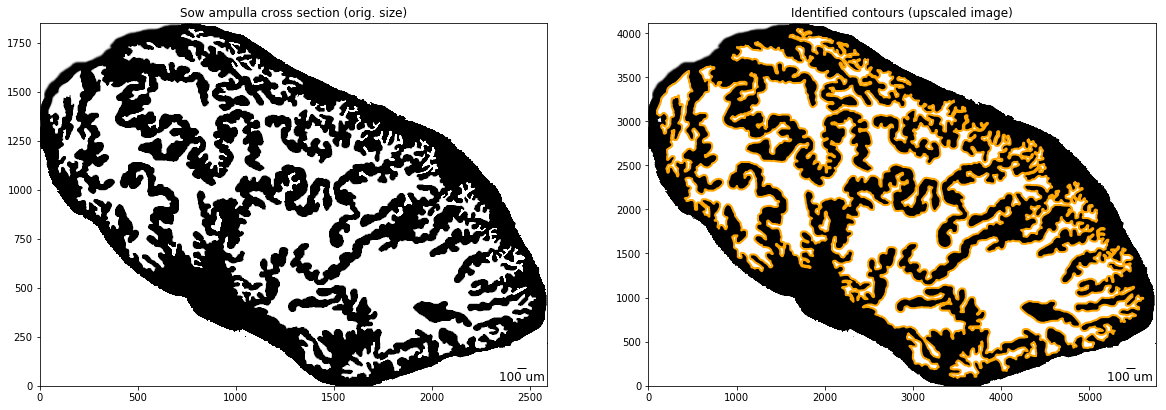

In [20]:
min_perimeter = 200
contours, greater_than_N = find_contours_in_foreground(img, img_upscaled, foreground, save = False, show = False, min_perimeter=min_perimeter)
# how many contours were found?, how many of them have more than N edges, and what are those?
print(f'A total of {len(contours)} contours were identified. From these, {len(greater_than_N)} have a perimeter of at least {min_perimeter} pixels.')

These will be further processed in the following steps to obtain the physical limits of the model. 

## EV potential starting point coordinates

Given that the extra cellular vesicles are produced by the oviduct epitheluim, the edges of the identified contours provide the vesicle's initial coordinates and the hypothetical locations of the source points producing the vesicles of our interest.


### Number of cells per edge

The manner in which the number of cells per edge was decided changed after each iteration of the modelling activity. Here,  a brief description of the major changes is presented.  

#### v1
Took the middle point between each pair of vertices on the polygon as a source point. The source points and the oviduct boundaries were independent concepts. Both were loaded as separate binary files, one was targetting the visual representation in visualisation, the other was purely oriented to collision detection.  
#### v2
The second version performed fixed-lenght subdivision of the poligon edges. If edgeLenght > 0.7 subdivide each edge in 6 parts, each part became a source point. Still source points and boundaries were independent concepts. Two binary files were still required.  
#### v3 (current)
After consulting with Dr Paul Richmond on the performance issues observed in our previous models, the number of checks for collisions was flagged as the main need for optimisation. It was sugested to change the logical representation of the boundaries from a list of line segments and turn them into agents. Then, instead of checking every vesicle agent for possible collisions against every segment in the boundaries, only those within the possible displacement range would be checked.

Such approach was estimated to require extensive modification to our model yet it would also enable exploring modelling other biological concepts observed in real cells. One of such concepts is the variations in cell distribution at different sections of the oviduct, which interestingly is also reported to change in close relation with the ovulation cycle. 

Therefore, after the changes were implemented, the new cell agents introduced in our model represent the phisical boundaries of the oviduct as obtained from the histology images but they also enable representing different types of cells with distinct behaviour.

Firsty, for the number of cells in a given edge, each edge is subdivided by an average oviductal cell diameter of $5 \mu m$ [x]. Then, in order to represent an average cell distributions of 50/50 ciliary/secretory [xx] at the ampulla, the fate of each cell is decided by sampling from an normally distributed random number generator (RNG). The cell will be ciliary if randomNumber &lt; 0.5 or secretory otherwise.  

Allocating the hypothetical cells on the edges.

### Shape simplification 
Due to the high complexity of the contour, most of the original edges have shorter length than the avg cells size. This works against our cell placement purposes. A solution for this is to simplify the shapes using less vertices. To do so, we use [`skimage.measure.approximate-polygon`](http://scikit-image.org/docs/0.14.x/api/skimage.measure.html#approximate-polygon).

After testing with different values for the tolerance we decided to use 0.1 because the shape it produces the closest perimeter to the original while producing a large number of cells which would enable reproducing the distributions described by [x]

| Tolerance | Vertices | Perimeter | Avg sized cells* | Smaller sized cells |
|-----------|----------|-------|-----------------|---------------------|
|0.0|76643.0|64701.93|0.0|76628.0|
|0.1|15814.0|64701.93|20539.0|7695.0|
|0.2|15318.0|64665.40|20539.0|7199.0|
|0.25|15316.0|64665.22|20539.0|7197.0|
|0.3|14816.0|64603.16|20766.0|6486.0|
|0.35|13988.0|64505.53|21150.0|5410.0|
|0.4|13368.0|64433.65|21479.0|4769.0|
|0.5|11791.0|64201.80|21992.0|3178.0|
|1.0|7154.0|63120.93|24337.0|209.0|
*note:* Average-sized-cells = $\sum$int(edge lenght/avg cell size)

In [19]:
# compare the cells fitted in the simplified contours
tolerances = [0.0, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 1.0]
avg_cell_size = 2.25
contours, greater_than_N, avg_cell_size
for tolerance in tolerances:
    simplify_contours(contours, greater_than_N, avg_cell_size, tolerance)

|0.0|171138.0|143481.22|0.0|171124.0|-> total:171124.0
|0.1|51950.0|143481.22|35251.0|38812.0|-> total:74063.0
|0.2|51284.0|143436.11|35251.0|38146.0|-> total:73397.0
|0.25|51284.0|143436.11|35251.0|38146.0|-> total:73397.0
|0.3|45985.0|142845.44|37900.0|30220.0|-> total:68120.0
|0.35|38761.0|141993.83|41320.0|20724.0|-> total:62044.0
|0.4|35075.0|141566.80|43400.0|16909.0|-> total:60309.0
|0.5|25449.0|140187.04|46659.0|6911.0|-> total:53570.0
|1.0|11573.0|137951.94|55284.0|160.0|-> total:55444.0


In [21]:
# simplify the contours without comparison
avg_cell_size = 2.25
simplified_contours, polygons = simplify_contours(contours, greater_than_N, avg_cell_size, 0.1)

|0.1|51950.0|143481.22|35251.0|38812.0|-> total:74063.0


In the biological process under scrutiny, the EVs are released from the oviduct wall and their initial displacement is to the inside of the tube. To capture this in our model, we need to define an initial direction for every source point. This direction will be directly dependant on the spatial charachteristics of each shape. 

### Visualise the source point directions
Our source point generation algorithm depends on the computed normal for each edge to provide the initial direction in which the EVs will displace. Because the polygons generated are described following the Right Hand Coordinate System (RHS)[http://www.ntu.edu.sg/home/ehchua/programming/opengl/CG_BasicsTheory.html] or Counter-Clockwise (CCW)[https://shapely.readthedocs.io/en/latest/manual.html#shapely.geometry.polygon.orient] direction, weu


In [ ]:
# optional
display_edge_with_normals(polygons, avg_cell_size=2.25, i=1)

## Computing the cell distributions

First identify the segments in each edge of the polygons

In [22]:
segments = identify_segments_in_polygons(polygons, avg_cell_size)
print(f'Computed {len(segments)} segments in all polygons')
threshold_secretory = 0.8
cells, secretory, ciliary = produce_cells(segments, True, threshold_secretory)
print(f'Generated {len(cells)} cells. The distribution is: {len(secretory)} secretory and {len(ciliary)} ciliary')

Computed 81211 segments in all polygons
Generated 81211 cells. The distribution is: 16294 secretory and 64917 ciliary


### Export & visualise the computed positions

The theoretical cell positions and their distributions are saved to the following files for future reuse

secretory, ciliary all_cells

In [54]:
export_computed_positions(base_filename, threshold_secretory, cells, secretory, ciliary)
# visualize_distributions(secretory, ciliary, threshold_secretory, False)

Exported file: ampulla_(3-1to3-5_L2-3_tr-amp)_2__distribution_80-20_s-c__secretory.pickle
Exported file: ampulla_(3-1to3-5_L2-3_tr-amp)_2__distribution_80-20_s-c__ciliary.pickle
Exported file: ampulla_(3-1to3-5_L2-3_tr-amp)_2__distribution_80-20_s-c__allCells.pickle


### Export Old file format
The computed segments/boundaries need to be exported in a format compatible with V1 of the model. This is only for comparison purposes between both models. 

Then, the two files generated need to be copied to the directory where the .EXE file is located prior to lauching the application. Their names must be '0_boundaries.evbin' and '0_starting_points.evbin'

In [59]:
#print(vertices_per_visual_section, sum(vertices_per_visual_section))
export_v1_bin_files(polygons, secretory)

boundaries file written: 0_boundaries.evbin
source_points file written: 0_starting_points.evbin
